In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

import os
import json

In [2]:
INPUT_WIDHT = 560
INPUT_HEIGHT = 1640

In [3]:
def load_data(path='./'):
    images = np.loadtxt(path + 'image_data.csv', delimiter=',').reshape(-1, 590, 1640)
    encoded_labels = np.loadtxt(path + 'label_data.csv', delimiter=',')
    bounds = np.loadtxt(path + 'bound_data.csv', delimiter=',')
    classes = np.loadtxt(path + 'labels.txt', dtype=np.object_)
    
    return images, encoded_labels, bounds, classes

In [4]:
images, encoded_labels, bounds, classes = load_data('../np_data/')

In [5]:
encoded_labels_categorical = tf.keras.utils.to_categorical(encoded_labels)

In [6]:
X = images[:]
Y = [tf.constant(bounds, dtype=tf.float32), encoded_labels_categorical]

In [7]:
X = np.expand_dims(images, axis=3)
X = tf.convert_to_tensor(X, dtype=tf.float32)

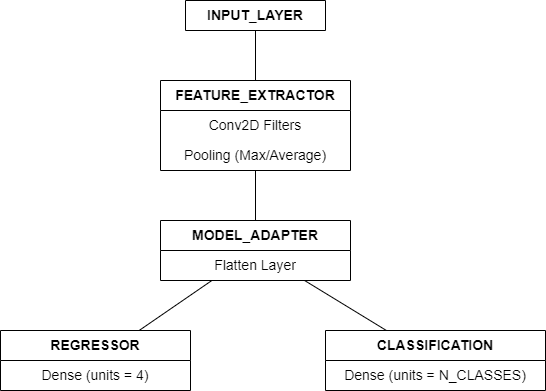

In [8]:
from PIL import Image
from IPython.display import display

img = Image.open('model_structure.png')
display(img)

In [9]:
DROPOUT_FACTOR = 0.5
CLASSES = 3

def standalize_input(inputs):
    
    x = tf.keras.layers.Lambda(lambda x: x/255.)(inputs)
    
    return x

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(4, kernel_size=3, activation='relu', input_shape=(590, 1640, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)
    
    x = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)
    
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name='classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(4, name='regressor_head')(inputs)

def build_model(inputs):
    
    input_standalizer = standalize_input(inputs)
    
    feature_extractor = build_feature_extractor(input_standalizer)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs=inputs, outputs=[regressor_head, classification_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head': 'categorical_crossentropy', 'regressor_head': 'mse' }, 
              metrics = {'classifier_head': 'accuracy', 'regressor_head': 'mse' },
              run_eagerly=True)

    return model

In [10]:
model = build_model(tf.keras.layers.Input(shape=(590, 1640, 1,)))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 590, 1640,   0           []                               
                                1)]                                                               
                                                                                                  
 lambda (Lambda)                (None, 590, 1640, 1  0           ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 588, 1638, 4  40          ['lambda[0][0]']                 
                                )                                                             

In [11]:
EPOCHS = 20
BATCH_SIZE = 16

history = model.fit(X, Y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/20
23/23 [==============================] - 74s 3s/step - loss: 0.9774 - regressor_head_loss: 0.0640 - classifier_head_loss: 0.9134 - regressor_head_mse: 0.0640 - classifier_head_accuracy: 0.4915
Epoch 2/20
23/23 [==============================] - 74s 3s/step - loss: 0.7473 - regressor_head_loss: 0.0309 - classifier_head_loss: 0.7164 - regressor_head_mse: 0.0309 - classifier_head_accuracy: 0.7119
Epoch 3/20
23/23 [==============================] - 72s 3s/step - loss: 0.5422 - regressor_head_loss: 0.0324 - classifier_head_loss: 0.5098 - regressor_head_mse: 0.0324 - classifier_head_accuracy: 0.7768
Epoch 4/20
23/23 [==============================] - 72s 3s/step - loss: 0.4625 - regressor_head_loss: 0.0362 - classifier_head_loss: 0.4263 - regressor_head_mse: 0.0362 - classifier_head_accuracy: 0.8277
Epoch 5/20
23/23 [==============================] - 75s 3s/step - loss: 0.3630 - regressor_head_loss: 0.0303 - classifier_head_loss: 0.3328 - regressor_head_mse: 0.0303 - classifier_he

In [16]:
evaluate = pd.DataFrame(history.history)

In [19]:
evaluate.to_csv('../model/evaluate.csv', index=False)

In [23]:
loss = evaluate['loss'].values
classification_loss = evaluate['classifier_head_loss']
regressor_loss = evaluate['regressor_head_loss']

Text(0.5, 1.0, 'regressor_loss')

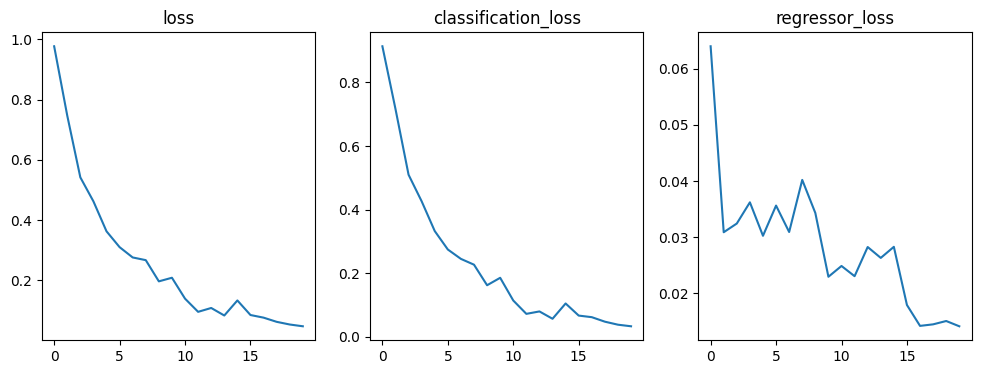

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(loss)
axes[1].plot(classification_loss)
axes[2].plot(regressor_loss)

axes[0].set_title('loss')
axes[1].set_title('classification_loss')
axes[2].set_title('regressor_loss')

# Save model

In [12]:
model.save('../model/tf_model.h5', save_format='h5')

# Load model

In [3]:
model = tf.keras.models.load_model('../model/tf_model.h5')

# Model Evaluation

In [45]:
def bound_rectangle(points, image_shape=(1, 1)):
    min_x = np.min(points[:, 0])
    max_x = np.max(points[:, 0])
    min_y = np.min(points[:, 1])
    max_y = np.max(points[:, 1])

    return [min_x, max_x, min_y, max_y], [min_x/image_shape[1], max_x/image_shape[1], min_y/image_shape[0], max_y/image_shape[0]]

def draw_rectangle(image, rect_shape):
    cv2.polylines(image, [np.array([[rect_shape[0], rect_shape[2]], [rect_shape[1], rect_shape[2]], [rect_shape[1], rect_shape[3]], 
                                    [rect_shape[0], rect_shape[3]]])], True, (255, 255, 255), 2)

In [46]:
def std_to_normal_bound(std_bound):
    return np.array([std_bound[0] * INPUT_HEIGHT, std_bound[1] * INPUT_HEIGHT, std_bound[2] * INPUT_WIDHT, std_bound[3] * INPUT_WIDHT]).astype(np.int32)

In [47]:
def draw_predict(image, bound, label):
    img = image[:]
    img = cv2.polylines(img, [np.array([[bound[0], bound[2]], [bound[1], bound[2]], [bound[1], bound[3]], 
                                    [bound[0], bound[3]]])], True, (0, 255, 0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (0, 0, 255)
    text_thickness = 2

    text_size, _ = cv2.getTextSize(label, font, font_scale, text_thickness)
    text_x = bound[0] + 5
    text_y = bound[2] - 10
    
    img = cv2.putText(img, label, (text_x, text_y), font, font_scale, font_color, text_thickness, cv2.LINE_AA)
    
    return img

In [48]:
test_image = cv2.imread('D:\\code\\py\\lane_object_detection\\data\\driver_37_30frame\\05181432_0203.MP4\\00360.jpg')

In [49]:
gr_img = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

In [50]:
# pred = model.predict(np.array([np.expand_dims(gr_img, axis=2)]))
pred = model.predict(np.array([X[1]]))

1/1 [==============================] - 0s 121ms/step


In [51]:
pred

[array([[0.02908554, 0.1142322 , 0.73510927, 0.81001914]], dtype=float32),
 array([[9.9775839e-01, 2.0086030e-03, 2.3302012e-04]], dtype=float32)]

In [52]:
Y[0][0].numpy()

array([0.30365855, 0.35243902, 0.5625    , 0.6017857 ], dtype=float32)

In [53]:
std_bound = pred[0][0]
label = classes[np.argmax(pred[1])]

In [54]:
label

'arrow'

In [55]:
bound = std_to_normal_bound(std_bound)

In [56]:
(bound[0], bound[2]), (bound[1], bound[3])

((47, 411), (187, 453))

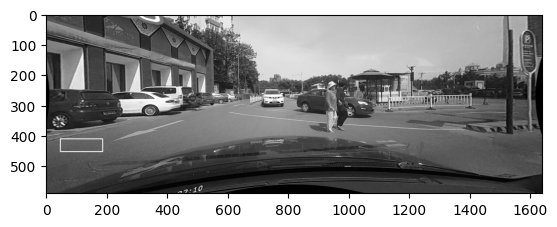

In [57]:
img = cv2.rectangle(X[1].numpy(), (bound[0], bound[2]), (bound[1], bound[3]), (255, 0, 0), 2)
plt.imshow(img, cmap='gray')